In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from torch import nn

In [3]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [4]:
mnist_train = datasets.FashionMNIST(
    root='data',
    transform=ToTensor(),
    target_transform=None,
    train=True)

mnist_test = datasets.FashionMNIST(
    root='data',
    transform=ToTensor(),
    target_transform=None,
    train=False)

In [6]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [8]:
class_names = mnist_train.classes

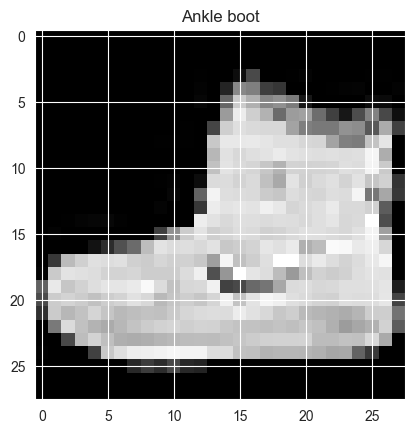

The shape of the image: torch.Size([1, 28, 28])


In [13]:
image, label = mnist_train[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"{class_names[label]}")
plt.show()
print(f"The shape of the image: {image.shape}")

In [14]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    dataset=mnist_train,
    pin_memory=True,
    shuffle=True,
    batch_size=32)

test_dataloader = DataLoader(
    dataset=mnist_test,
    pin_memory=True,
    shuffle=False,
    batch_size=32)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
class FashionMnistModel_V1(nn.Module):
    def __init__(self, input_shape:int, hidden_shape:int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_shape,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten_layer = nn.Sequential(
            nn.Flatten()
        )
        self.final_layer = nn.Sequential(
            nn.Linear(in_features=hidden_shape*7*7, out_features=output_shape),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten_layer(x)
        x = self.final_layer(x)
        return x

In [22]:
mnist_model = FashionMnistModel_V1(input_shape=1, hidden_shape=32, output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=mnist_model.parameters(),
                            lr=0.01)

In [23]:
from tqdm.auto import tqdm

In [24]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

In [31]:
epochs = 3

def train_step(data_loader: DataLoader,
               model: nn.Module,
               loss_fn: nn.Module,
               accuracy_fn,
               device):
    train_loss, train_accuracy = 0, 0
    model.train()
    for batch_train, (X_train, y_train) in enumerate(data_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred_train = model(X_train)
        loss = loss_fn(y_pred_train, y_train)
        train_loss += loss
        train_accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred_train.argmax(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)
    
    print(f"Training loss is {train_loss:.4f}, Training accuracy is {train_accuracy:.4f}")

In [33]:
def test_step(data_loader: DataLoader,
               model: nn.Module,
               loss_fn: nn.Module,
               accuracy_fn,
               device):
    test_loss, test_accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch_test, (X_test, y_test) in enumerate(data_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred_test = model(X_test)
            test_loss += loss_fn(y_pred_test, y_test)
            test_accuracy += accuracy_fn(y_true=y_test, y_pred=y_pred_test.argmax(1))
    
        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)
    
    print(f"Testing loss is {test_loss}, Testing accuracy is {test_accuracy}")

In [35]:
from timeit import default_timer as timer

epochs = 3

INITIAL_TIME = timer()

for epoch in tqdm(range(epochs)):
    
    train_step(data_loader=train_dataloader,
               model=mnist_model,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(data_loader=test_dataloader,
               model=mnist_model,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
ENDING_TIME = timer()
TOTAL_TIME = ENDING_TIME - INITIAL_TIME
print(f"The model training takes {TOTAL_TIME:.4f} seconds.")

  0%|          | 0/3 [00:00<?, ?it/s]

Training loss is 1.7544, Training accuracy is 0.0417
Testing loss is 1.756425380706787, Testing accuracy is 70.54712460063898
Training loss is 1.7509, Training accuracy is 0.0367
Testing loss is 1.7591801881790161, Testing accuracy is 70.06789137380191
Training loss is 1.7492, Training accuracy is 0.0333
Testing loss is 1.7553880214691162, Testing accuracy is 70.59704472843451
The model training takes 58.6397 seconds.


In [37]:
class FashionMnistModel_V2(nn.Module):
    def __init__(self,
                 input_layer: int,
                 hidden_layers: int,
                 output_layer: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_layer, out_features=hidden_layers),
            nn.Linear(in_features=hidden_layers, out_features=output_layer)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [42]:
mnist_model_v2 = FashionMnistModel_V2(input_layer=28*28, hidden_layers=32, output_layer=len(class_names)).to(device)

In [43]:
from timeit import default_timer as timer

epochs = 3

INITIAL_TIME = timer()

for epoch in tqdm(range(epochs)):
    
    train_step(data_loader=train_dataloader,
               model=mnist_model_v2,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(data_loader=test_dataloader,
               model=mnist_model_v2,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
ENDING_TIME = timer()
TOTAL_TIME = ENDING_TIME - INITIAL_TIME
print(f"The model training takes {TOTAL_TIME:.4f} seconds.")

  0%|          | 0/3 [00:00<?, ?it/s]

Training loss is 2.3358, Training accuracy is 0.0033
Testing loss is 2.336124897003174, Testing accuracy is 8.576277955271566
Training loss is 2.3358, Training accuracy is 0.0067
Testing loss is 2.336124897003174, Testing accuracy is 8.576277955271566
Training loss is 2.3358, Training accuracy is 0.0067
Testing loss is 2.336124897003174, Testing accuracy is 8.576277955271566
The model training takes 48.2179 seconds.


# Model Comparison

In [46]:
def eval_model(data_loader: DataLoader,
               model: nn.Module,
               loss_fn: nn.Module,
               accuracy_fn,
               device):
    test_loss, test_accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch_test, (X_test, y_test) in enumerate(data_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred_test = model(X_test)
            test_loss += loss_fn(y_pred_test, y_test)
            test_accuracy += accuracy_fn(y_true=y_test, y_pred=y_pred_test.argmax(1))
    
        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)
    
    return {
        "model_name": model.__class__.__name__,
        "model_loss": test_loss.item(),
        "model_acc": test_accuracy
    }

In [61]:
model_v1_results= eval_model(data_loader=test_dataloader,
               model=mnist_model,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

In [62]:
model_v2_results = eval_model(data_loader=test_dataloader,
               model=mnist_model_v2,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

In [63]:
model_v1_results

{'model_name': 'FashionMnistModel_V1',
 'model_loss': 1.7553880214691162,
 'model_acc': 70.59704472843451}

In [64]:
model_v2_results

{'model_name': 'FashionMnistModel_V2',
 'model_loss': 2.336124897003174,
 'model_acc': 8.576277955271566}

In [65]:
results_comparisons = pd.DataFrame([model_v1_results, model_v2_results])
results_comparisons

,model_name,model_loss,model_acc
0,FashionMnistModel_V1,1.755388,70.597045
1,FashionMnistModel_V2,2.336125,8.576278


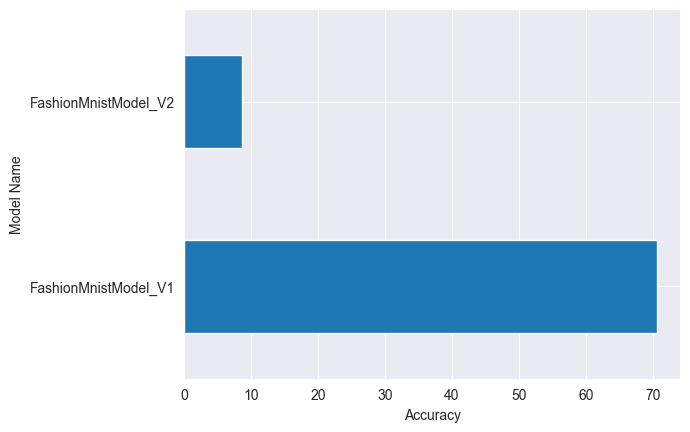

In [69]:
results_comparisons.set_index("model_name")['model_acc'].plot(kind='barh')
plt.xlabel("Accuracy")
plt.ylabel("Model Name")
plt.show()

In [81]:
def make_predictions(data: list,
               model: nn.Module,
               device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)
            sample = sample.to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs)

In [82]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(mnist_test), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [83]:
pred_probs= make_predictions(model=mnist_model, 
                             data=test_samples,
                             device=device)

In [88]:
pred_probs

tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.2320],
        [0.0853, 0.2319, 0.0853, 0.0854, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.2313, 0.0854,
         0.0857],
        [0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0854, 0.0853, 0.0853, 0.2318, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853],
        [0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.2319, 0.0854,
         0.0853],
        [0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853]], device='cuda:0')

In [90]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 1, 7, 4, 3, 0, 4, 7, 1], device='cuda:0')

In [91]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1],
 tensor([9, 1, 7, 4, 3, 0, 4, 7, 1], device='cuda:0'))

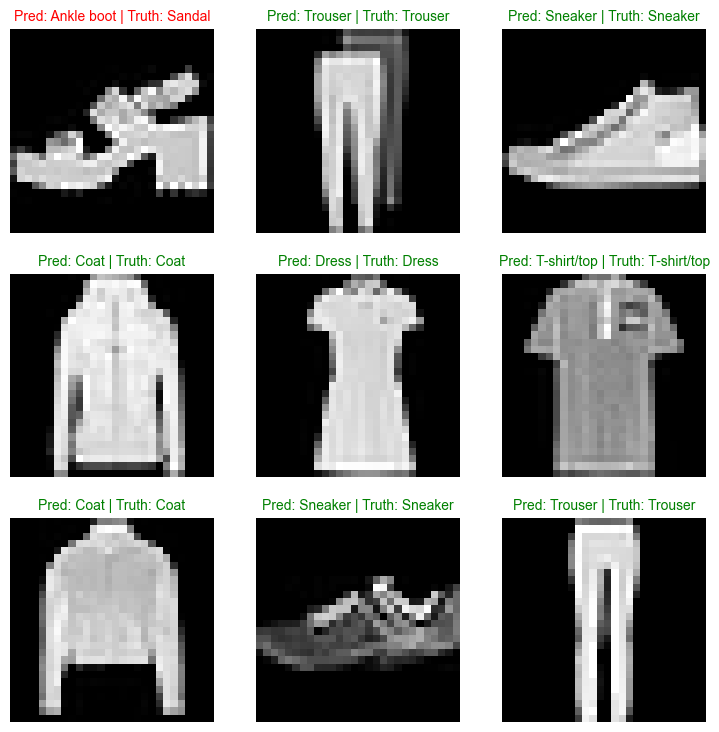

In [92]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong

In [94]:
y_preds = []
mnist_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = mnist_model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

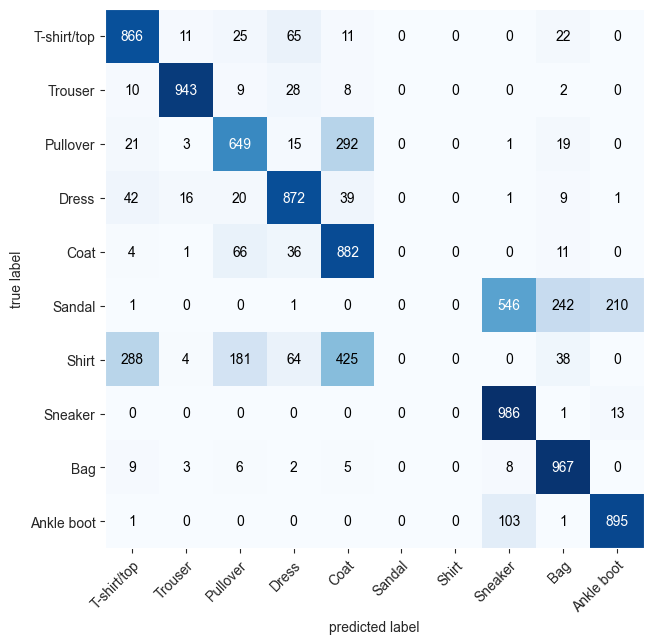

In [96]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=mnist_test.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [97]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, 
                 exist_ok=True)

MODEL_NAME = "PyTorch_CVV.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=mnist_model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\PyTorch_CVV.pth


# Loading Model

In [116]:
loaded_model = FashionMnistModel_V1(input_shape=1, 
                                    hidden_shape=32, # try changing this to 128 and seeing what happens 
                                    output_shape=10)

In [117]:
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [118]:
loaded_model = loaded_model.to(device=device)

In [119]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn,
    device=device)

loaded_model_results

{'model_name': 'FashionMnistModel_V1',
 'model_loss': 1.7553880214691162,
 'model_acc': 70.59704472843451}

In [120]:
model_v1_results

{'model_name': 'FashionMnistModel_V1',
 'model_loss': 1.7553880214691162,
 'model_acc': 70.59704472843451}

In [121]:
torch.isclose(torch.tensor(model_v1_results["model_loss"]), 
              torch.tensor(loaded_model_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)